In [1]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import matplotlib as mpl
from matplotlib import pyplot as plt

from psyfun import io, atlas, spikes
from psyfun.config import paths, cmaps

In [2]:
df_sessions = pd.read_csv(paths['sessions'])  # session info
df_sessions = io.add_postLSD_epochs(df_sessions)
df_units = pd.read_parquet(paths['units'])  # unit info

In [3]:
# Get eids for sessions with both tasks
df_sessionquery = df_sessions.query('n_tasks == 2')
eids = df_sessions['eid'].tolist()

# Find good-quality units from those sessions
df_unitquery = df_units.query('eid in @eids and ks2_label == "good"')


# Load spike times for good units
uuids = df_unitquery['uuid']
df_spiketimes = io.load_units(paths['spikes'], uuids)
df_spikes = df_unitquery.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_spikes = pd.merge(df_spikes, df_sessions, on='eid', how='left')
df_spikes['acronym'] = df_spikes['acronym'].replace({'none':np.nan})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11544/11544 [00:05<00:00, 2102.04it/s]


In [4]:
epochs = ['task00_spontaneous', 'LSD0', 'LSD600', 'LSD1200', 'task01_spontaneous']
dt = 1  # get spike counts in 1s bins

for epoch in epochs:
    print(f"Getting spike counts for: {epoch}")
    df_spikes[f'{epoch}_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch=epoch, dt=dt, axis='columns')
    df_spikes[f'{epoch}_rate'] = df_spikes[f'{epoch}_counts'].apply(lambda x: (x / dt).mean())

Getting spike counts for: task00_spontaneous


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11544/11544 [00:03<00:00, 3782.28it/s]


Getting spike counts for: LSD0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11544/11544 [00:02<00:00, 3935.51it/s]


Getting spike counts for: LSD600


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11544/11544 [00:02<00:00, 3987.41it/s]


Getting spike counts for: LSD1200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11544/11544 [00:02<00:00, 3943.83it/s]


Getting spike counts for: task01_spontaneous


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11544/11544 [00:02<00:00, 4585.22it/s]


/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


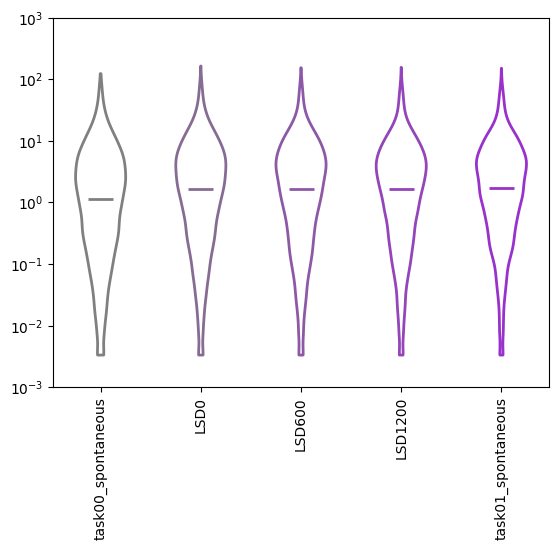

In [5]:
fig, ax = plt.subplots()
cmap = cmaps['LSD']
colors = cmap(np.linspace(0, 1, len(epochs))) 

xpos = np.arange(len(epochs))
rates = [np.log10(df_spikes[f'{epoch}_rate']).replace(-np.inf, np.nan).dropna() for epoch in epochs]
violins = ax.violinplot(rates, positions=xpos, showmedians=True, showextrema=False)
for violin, color in zip(violins['bodies'], colors):
    violin.set_facecolor('none')
    violin.set_edgecolor(color)
    violin.set_linewidth(2)
    violin.set_alpha(1)
violins['cmedians'].set_edgecolor(colors)
violins['cmedians'].set_linewidth(2)
ax.set_xticks(xpos)
ax.set_xticklabels(epochs)
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.linspace(-3, 3, 7))
ax.set_yticklabels(['$10^{%d}$' % tick for tick in np.linspace(-3, 3, 7)])
ax.set_label('log(rate)')

In [6]:
# Get firig rate modulation index
epochs = ['task00_spontaneous', 'task01_spontaneous']

df_spikes['MI'] = df_spikes.progress_apply(spikes._get_modulation_index, epochs=epochs, axis='columns')
df_spikes['MI_p'] = df_spikes['MI'].apply(lambda x: x[1])
df_spikes['MI'] = df_spikes['MI'].apply(lambda x: x[0])

  0%|▌                                                                                                                            | 47/11544 [00:03<13:40, 14.02it/s]/home/crombie/code/ibl_psychedelics/psyfun/spikes.py:24: RuntimeWarning: invalid value encountered in divide
  return np.squeeze(np.diff(rates, axis=0) / np.sum(rates, axis=0))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11544/11544 [08:33<00:00, 22.47it/s]


In [8]:
columns_to_keep = [
    'uuid', 'eid', 'subject_x', 'n_probes', 'n_tasks', 'start_time', 
    'amp_median', 'contamination', 'drift', 'label', 
    'x', 'y', 'z', 'acronym', 
    'MI', 'MI_p'
]
df_spikes[columns_to_keep].to_parquet('data/singleunit_MI.pqt')

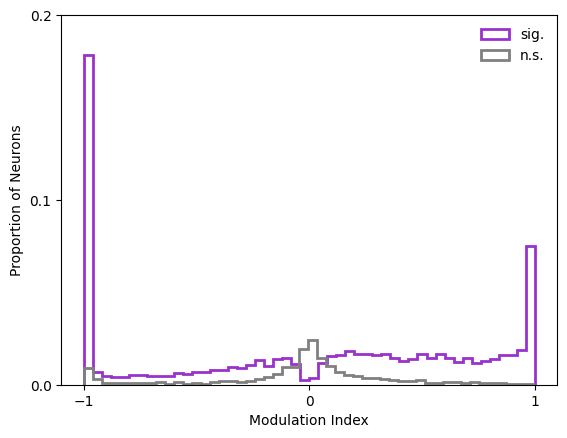

In [9]:
fig, ax = plt.subplots()

queries = [
    'MI_p <= 0.025 or MI_p >= 0.975',
    'MI_p > 0.025 and MI_p < 0.975'
]
cmap = cmaps['LSD']
colors = [cmap(1.), cmap(0.)]

for query, color, label in zip(queries, colors, ['sig.', 'n.s.']):
    df = df_spikes.query(query)
    weights = np.ones(len(df)) / len(df_spikes)
    ax.hist(df['MI'], bins=50, weights=weights, histtype='step', linewidth=2, color=color, label=label)

ax.set_xticks([-1, 0, 1])
ax.set_xlabel('Modulation Index')
ax.set_yticks([0, 0.1, 0.2])
ax.set_ylabel('Proportion of Neurons')
ax.legend(loc='upper right', frameon=False)

In [10]:
# Make a df only with units mapped to a region
df_regions = df_spikes.dropna(subset='acronym').copy()
# Merge region acronyms into coarse regions
df_regions['region'] = atlas.combine_regions(df_regions['acronym'])
df_regions = df_regions.query('region != "root"')

/tmp/ipykernel_128985/2904921141.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.bar(xpos, MIs[sorted_inds], yerr=yerr[sorted_inds], fc=colors[sorted_inds], ec='gray')
/tmp/ipykernel_128985/2904921141.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for x, y, n in zip(xpos, MIs[sorted_inds], n_sessions[sorted_inds]):


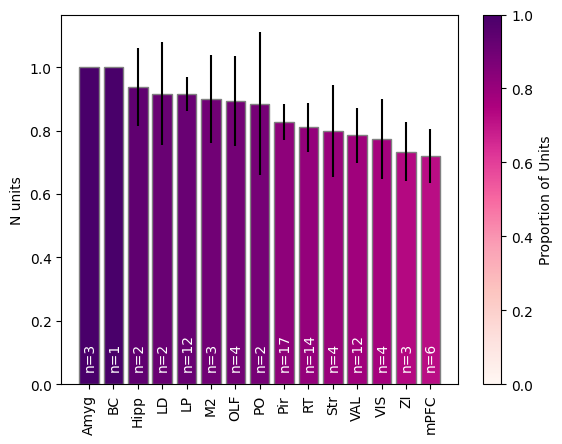

In [11]:
fig, ax = plt.subplots()
n_regions = 50

# Count neurons per region-eid
n_neurons = df_regions.groupby(['region', 'eid']).size()

# Count neurons with significant modualtion (2-sided test) per region-eid
n_significant = df_regions.query('MI_p < 0.025 or MI_p > 0.975').groupby(['region', 'eid']).size()

# Proportion of significant neurons
MI_props = (n_significant / n_neurons).reset_index(name='MI_prop').query('region != "root"')
MI_regions = MI_props.groupby('region')['MI_prop']

MIs = MI_regions.mean()
yerr = MI_regions.sem() * 1.96
n_sessions = MI_regions.size()
sorted_inds = np.argsort(-1 * MIs)
xpos = np.arange(len(MIs))

cmap = cmaps['n_units']
colors = np.array([cmap(p) for p in MIs / MIs.max()])

ax.bar(xpos, MIs[sorted_inds], yerr=yerr[sorted_inds], fc=colors[sorted_inds], ec='gray')
ax.set_xticks(np.arange(len(MIs)))
ax.set_xticklabels(MIs.index)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('N units')

for x, y, n in zip(xpos, MIs[sorted_inds], n_sessions[sorted_inds]):
    ax.text(x - 0.25, 0.05, f'n={n}', color='white', rotation=90)  

mappable = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, MIs.max()), cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, label='Proportion of Units')

/tmp/ipykernel_128985/1692064383.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.bar(xpos, MIs[sorted_inds], yerr=yerr[sorted_inds], fc=colors[sorted_inds], ec='gray')


Text(0, 0.5, 'Modulation Index')

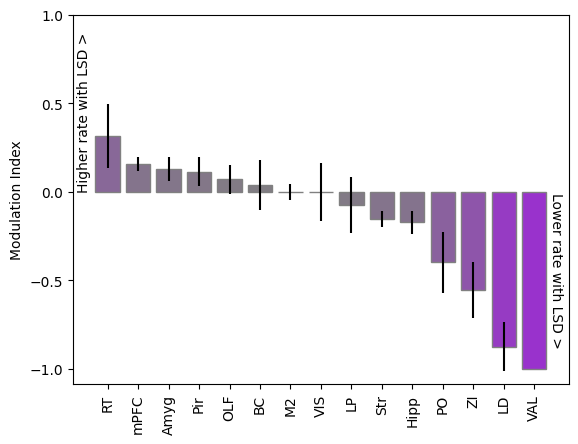

In [12]:
fig, ax = plt.subplots()

regions = df_regions.query('MI_p < 0.025 or MI_p > 0.975').groupby('region')
MIs = regions['MI'].mean()
yerr = regions['MI'].sem() * 1.96
sorted_inds = np.argsort(-1 * MIs)
xpos = np.arange(len(MIs))

cmap = cmaps['LSD']
colors = np.array([cmap(p) for p in np.abs(MIs) / np.abs(MIs).max()])

ax.bar(xpos, MIs[sorted_inds], yerr=yerr[sorted_inds], fc=colors[sorted_inds], ec='gray')
ax.text(xpos[0] - 1, 0, 'Higher rate with LSD >', va='bottom', rotation=90)
ax.text(xpos[-1] + 0.5, 0, 'Lower rate with LSD >', va='top', rotation=270)
ax.set_xticks(np.arange(len(MIs)))
ax.set_xticklabels(MIs.index[sorted_inds])
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_ylabel('Modulation Index')

/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_128985/3290706711.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.bar(xpos, MI[sorted_inds], yerr=yerr[sorted_inds], fc='none', ec='black')


Text(0, 0.5, 'Modulation Index Ratio')

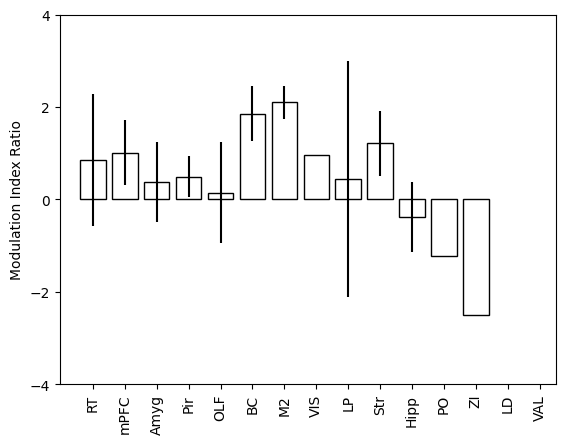

In [13]:
fig, ax = plt.subplots()

df_regions['MI_pos'] = df_regions.apply(lambda x: (x['MI_p'] > 0.975) & (x['MI'] > 0), axis='columns')
MI_pos = df_regions.groupby(['region', 'eid'])['MI_pos'].mean()
df_regions['MI_neg'] = df_regions.apply(lambda x: (x['MI_p'] < 0.025) & (x['MI'] < 0), axis='columns')
MI_neg = df_regions.groupby(['region', 'eid'])['MI_neg'].mean()
MI_ratio = np.log2(MI_pos / MI_neg).replace({np.inf:np.nan, -np.inf:np.nan})

MI = MI_ratio.groupby('region').mean()
yerr = MI_ratio.groupby('region').sem() * 1.96
xpos = np.arange(len(MI))

ax.bar(xpos, MI[sorted_inds], yerr=yerr[sorted_inds], fc='none', ec='black')
ax.set_xticks(xpos)
ax.set_xlim(right=xpos[-1] + 0.5)
ax.set_xticklabels(MI.index[sorted_inds])
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.linspace(-4, 4, 5))
ax.set_ylabel('Modulation Index Ratio')

In [27]:
# df_units_bwm = pd.read_csv('data/BWM_units.csv')